In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#load the cleaned dataset
df = pd.read_csv('Fire_Events_Cleaned.csv')

/var/folders/9p/_b4dc0y971nch8xw548c1hjh0000gn/T/ipykernel_55561/1350652573.py:2: DtypeWarning: Columns (30) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Fire_Events_Cleaned.csv')


In [3]:
import pandas as pd

def detect_unusual_behavior(df):
    """
    Identifies suspicious detector isolation patterns from event logs.

    Returns:
        - suspicious_isolations: Isolations shortly after faults (within 10 mins)
        - frequent_isolations: Detectors isolated >3 times per week
        - repeat_patterns: Detectors isolated repeatedly at same day/hour
    """
    # Select useful columns
    cols = ['DETECTORID', 'ADDEDAT', 'fault', 'isolate', 'zone', 'descriptor']
    df = df[cols].copy()

    # Time formatting and sorting
    df['ADDEDAT'] = pd.to_datetime(df['ADDEDAT'])
    df = df.sort_values(['DETECTORID', 'ADDEDAT'])

    # Event history (previous fault and event time)
    df['prev_fault'] = df.groupby('DETECTORID')['fault'].shift(1)
    df['time_since_prev'] = (
        df['ADDEDAT'] - df.groupby('DETECTORID')['ADDEDAT'].shift(1)
    ).dt.total_seconds() / 60  # in minutes

    # Flag suspicious isolations: "isolate on" after "fault on" within 10 mins
    df['suspicious_isolation'] = (
        (df['prev_fault'] == 'on') &
        (df['isolate'] == 'on') &
        (df['time_since_prev'] <= 10)
    ).astype(int)

    # Extract hour/day of week
    df['hour'] = df['ADDEDAT'].dt.hour
    df['day_of_week'] = df['ADDEDAT'].dt.day_name()

    # Weekly isolation count
    weekly_isolations = (
        df[df['isolate'] == 'on']
        .groupby(['DETECTORID', pd.Grouper(key='ADDEDAT', freq='W-MON')])
        .size()
        .reset_index(name='isolation_count')
    )
    weekly_isolations['frequent_isolations'] = (weekly_isolations['isolation_count'] > 3).astype(int)

    # Repeated patterns: Same day/hour isolations
    repeat_patterns = (
        df[df['isolate'] == 'on']
        .groupby(['DETECTORID', 'zone', 'day_of_week', 'hour'])
        .size()
        .reset_index(name='count')
    )
    repeat_patterns = repeat_patterns[repeat_patterns['count'] >= 3]

    # Reports
    suspicious_isolations = df[df['suspicious_isolation'] == 1][[
        'DETECTORID', 'zone', 'ADDEDAT', 'prev_fault',
        'time_since_prev', 'day_of_week', 'hour'
    ]]
    frequent_isolations = weekly_isolations[weekly_isolations['frequent_isolations'] == 1]

    # Group by DETECTORID, day_of_week, and hour, and count occurrences across weeks
    df['week'] = df['ADDEDAT'].dt.isocalendar().week
    consistent_patterns = (
        df[df['isolate'] == 'on']
        .groupby(['DETECTORID', 'zone', 'day_of_week', 'hour', 'week'])
        .size()
        .reset_index(name='count')
    )
    # Aggregate to see how many weeks this pattern occurs
    consistent_patterns = (
        consistent_patterns.groupby(['DETECTORID', 'zone', 'day_of_week', 'hour'])
        .size()
        .reset_index(name='week_count')
    )
    # Filter for patterns that occur in at least 3 different weeks (indicating consistency)
    consistent_patterns = consistent_patterns[consistent_patterns['week_count'] >= 3]

    # Create a flag for Fault On events
    df['fault_on'] = (df['fault'] == 'on').astype(int)
    df['isolate_on'] = (df['isolate'] == 'on').astype(int)

    # Group by DETECTORID and a time window (e.g., 1-hour window) to count co-occurrences
    co_occurrence = (
        df.groupby(['DETECTORID', pd.Grouper(key='ADDEDAT', freq='H')])
        .agg({'fault_on': 'sum', 'isolate_on': 'sum'})
        .reset_index()
    )
    # Filter for instances where both fault and isolation occur in the same hour
    co_occurrence = co_occurrence[(co_occurrence['fault_on'] > 0) & (co_occurrence['isolate_on'] > 0)]
    co_occurrence = (
        co_occurrence.groupby('DETECTORID')
        .size()
        .reset_index(name='co_occurrence_count')
    )
    # Merge with zone and descriptor for better reporting
    co_occurrence = co_occurrence.merge(
        df[['DETECTORID', 'zone', 'descriptor']].drop_duplicates(),
        on='DETECTORID',
        how='left'
    )

    return suspicious_isolations, frequent_isolations, repeat_patterns, consistent_patterns, co_occurrence


In [ ]:
"""
The generate_narrative function aims to turn the results of data analysis into stories that are easy to understand, like a normal conversation.

So, it takes data from five analysis results (suspicious, frequent, repeat, consistent, and co_occurrence), then adds data from df, then turns it into simple sentences. 

The goal is for people who read it to immediately understand what's happening with the detector, for example, something strange like a lot of isolation, a fault that is always followed by isolation, or the same pattern every day and hour. 

So, it's not just raw data, but directly tells you in the form of a story, like ‘The detector in the warehouse is isolated every Friday at 3 pm, this is a bit odd, let's check it’.
"""
def generate_narrative(suspicious, frequent, repeat, consistent, co_occurrence, df):
    narrative = []

    # Suspicious Isolations
    if not suspicious.empty:
        for _, row in suspicious.head().iterrows():
            detector_id = row['DETECTORID']
            zone = row['zone']
            day = row['day_of_week']
            hour = row['hour']
            narrative.append(
                f"Detector {detector_id} in zone {zone} had a fault followed by an isolation within {row['time_since_prev']:.1f} minutes "
                f"on {day} at {hour}:00. This might indicate tampering."
            )

    # Frequent Isolations
    if not frequent.empty:
        for _, row in frequent.head().iterrows():
            detector_id = row['DETECTORID']
            count = row['isolation_count']
            week_start = row['ADDEDAT'].strftime('%Y-%m-%d')
            zone = df[df['DETECTORID'] == detector_id]['zone'].iloc[0]
            narrative.append(
                f"Detector {detector_id} in zone {zone} was isolated {count} times during the week starting {week_start}. "
                f"This frequent isolation is unusual and should be checked."
            )

    # Consistent Patterns
    if not consistent.empty:
        for _, row in consistent.head().iterrows():
            detector_id = row['DETECTORID']
            zone = row['zone']
            day = row['day_of_week']
            hour = row['hour']
            week_count = row['week_count']
            location = df[df['DETECTORID'] == detector_id]['descriptor'].iloc[0]
            narrative.append(
                f"A detector {detector_id} in {location} (zone {zone}) is isolated every {day} at {hour}:00 for {week_count} weeks. "
                f"This consistent pattern is unusual and should be investigated."
            )

    # Co-occurrence of Fault and Isolation
    if not co_occurrence.empty:
        for _, row in co_occurrence.head().iterrows():
            detector_id = row['DETECTORID']
            count = row['co_occurrence_count']
            zone = row['zone']
            location = row['descriptor']
            narrative.append(
                f"Detector {detector_id} in {location} (zone {zone}) had fault and isolation events occurring together {count} times "
                f"within the same hour. This frequent pairing might suggest tampering."
            )

    return narrative

In [7]:
# Get results from the analysis
suspicious, frequent, repeat, consistent, co_occurrence = detect_unusual_behavior(df)

# Generate narrative output
narrative = generate_narrative(suspicious, frequent, repeat, consistent, co_occurrence, df)
print("\n=== Unusual Detector Behavior Report ===")
for line in narrative:
    print(line)


=== Unusual Detector Behavior Report ===
Detector 08P2leknJ9LwQTWv8kiJ in zone 197.0 had a fault followed by an isolation within 0.5 minutes on Monday at 1:00. This might indicate tampering.
Detector 0AG52AI6uqmPwOPZuPVj in zone 329.0 had a fault followed by an isolation within 0.5 minutes on Wednesday at 1:00. This might indicate tampering.
Detector 0AG52AI6uqmPwOPZuPVj in zone 329.0 had a fault followed by an isolation within 0.0 minutes on Wednesday at 1:00. This might indicate tampering.
Detector 0BTVxaeMQXEMQWNULvk0 in zone 326.0 had a fault followed by an isolation within 0.1 minutes on Monday at 12:00. This might indicate tampering.
Detector 0MsG5L06Zdg4dXE6JfoF in zone 320.0 had a fault followed by an isolation within 4.3 minutes on Tuesday at 0:00. This might indicate tampering.
Detector 0107Bek7Xoa25V5QtbgV in zone 44.0 was isolated 5 times during the week starting 2024-09-02. This frequent isolation is unusual and should be checked.
Detector 08Mp4An3uljGEZaTnV2U in zone 71.

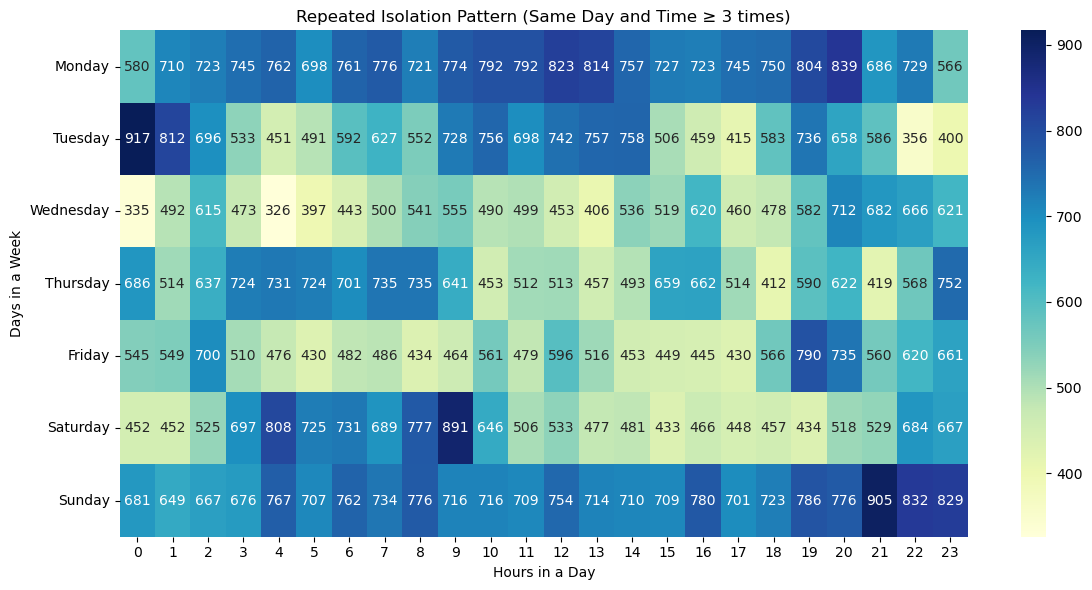

In [14]:
# Create a pivot table for the heatmap
pivot_table = repeat.pivot_table(
    index='day_of_week',
    columns='hour',
    values='count',
    aggfunc='sum',
    fill_value=0
)

# Define the order of days for consistent visualization
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
pivot_table = pivot_table.reindex(days_order)

# Plot the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table, cmap='YlGnBu', annot=True, fmt='d')
plt.title('Repeated Isolation Pattern (Same Day and Time ≥ 3 times)')
plt.xlabel('Hours in a Day')
plt.ylabel('Days in a Week')
plt.tight_layout()
plt.show()